<a href="https://colab.research.google.com/github/rahul-ohlan/TWARP/blob/main/imdb_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/gdrive/")
%cd "/gdrive/"

Mounted at /gdrive/
/gdrive


In [2]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 74.3 MB/s eta 0:00:00


## Load and Preprocess Data

In [3]:
# import libraries
import os
import random
import pickle
from timeit import default_timer as timer

import re
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download("stopwords")
from string import punctuation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.utils import class_weight

from transformers import TFAutoModel, BertTokenizerFast, BertModel
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import callbacks as cb
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.constraints import MaxNorm
import keras
from keras.layers import Input, Concatenate, Flatten, Embedding, Dense, Dropout, LSTM
from keras.models import Model, Sequential
from keras.layers import Lambda

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def SEED_EVERYTHING(seed_val):
  random.seed(seed_val)
  np.random.seed(seed_val)
  # torch.manual_seed(seed_val)
  # torch.cuda.manual_seed_all(seed_val)
  tf.random.set_seed(seed_val)
  return

seed = 47
SEED_EVERYTHING(seed)

In [5]:
def text_preprocessing(text,                                                               # text is a word string ex. 'rahul in ny'
                      punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
                      stop_words = set(stopwords.words("english"))) -> list:  
    
        '''
        A method to preprocess text
        
        '''

        for x in text.lower():
            if x in punctuations:
                text = text.replace(x,"")
                
        # removing words that have numbers in them
        text = re.sub(r'\w*\d\w*', '', text)
        # remove digits
        text = re.sub(r'[0-9]+', ' ', text)
        
        # clean the whitespaces
        
        text = re.sub(r'\s+', ' ', text).strip()
        
        
        
        # convert all text to a list
        
        # text = text.split(' ').  # uncomment if list required
        emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text) # no emoji

        # lowercase eth
        
        text = text.lower()
        
        
        # drop the stop words
        

        
        # add the tags

        return text

In [11]:
# IMDB Dataset
dataframe = pd.read_csv('/gdrive/Shareddrives/Thesis/datasets/IMDB_Dataset.csv')
dataframe["sentiment"] = dataframe["sentiment"].apply(lambda x : 1.0 if x == "positive" else 0.0)
dataframe = dataframe.sample(frac = 1, random_state = 47).reset_index(drop = True)
dataframe["review"] = dataframe["review"].apply(lambda x : text_preprocessing(x))
dataframe

,review,sentiment
0,cleos second husband is an amateurish attempt ...,0.0
1,first of all i would like to clarify that i co...,0.0
2,volcano is set in los angeles where a minor ea...,0.0
3,this must have been one of chaplins most ambit...,1.0
4,military training films are becoming so common...,1.0
...,...,...
49995,happenstance is the most new yorkfeeling paris...,1.0
49996,this film tried to capitalize on the much bett...,1.0
49997,another of many nearly forgotten movies cranke...,0.0
49998,few movies have dashed expectations and upset ...,0.0


In [12]:
# class imbalance?
dataframe["sentiment"].value_counts(normalize=True)

0.0    0.5
1.0    0.5
Name: sentiment, dtype: float64

In [13]:
# NO Apparent Class Imbalance

In [14]:
np.linspace(0,10,4)

array([ 0.        ,  3.33333333,  6.66666667, 10.        ])

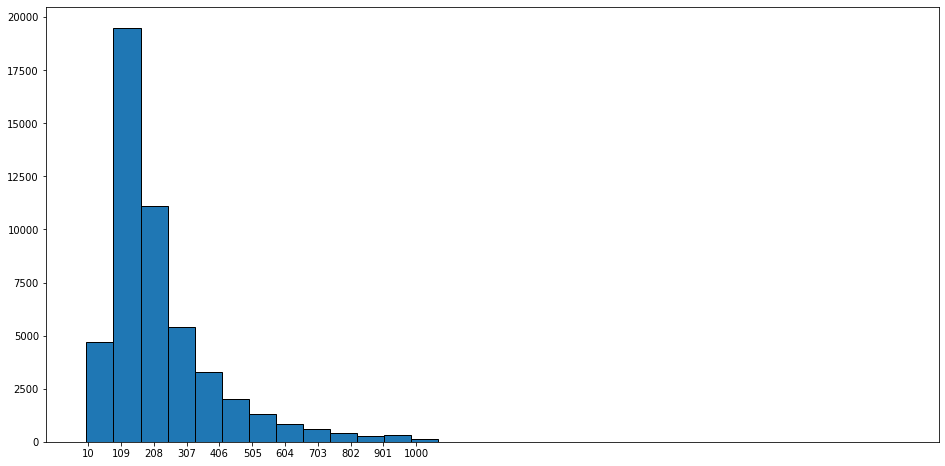

In [15]:
# token lengths distribution in the dataset
token_lengths = [len(i.split()) for i in dataframe["review"]]
plt.figure(figsize=(16,8))
plt.hist(token_lengths,bins = 30,edgecolor="black")
plt.xticks(ticks = np.linspace(10,1000,11))
plt.show()

In [16]:
# token_length 128, seems a good fit for data
train_df, temp_df = train_test_split(dataframe, test_size= 0.30, stratify= dataframe["sentiment"], random_state = 47)

val_df,   test_df   = train_test_split(temp_df, test_size= 0.50, stratify= temp_df["sentiment"],random_state = 47)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop  = True)
test_df  = test_df.reset_index(drop = True)

In [17]:
# load bertModel, bertTokenizer and freeze all layers
bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bertModel.trainable = False

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [18]:
bertModel.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


In [19]:
# dataset generator (input to tf.data.Dataset.from_generator())
class dataset:
  
  def __init__(self,text,labels,max_length, tokenizer,projection_dim, val = False):

    self.text =   text
    self.labels = labels
    self.max_length = max_length
    self.tokenizer = tokenizer
    self.flag = val
    self.projection_dim = projection_dim

  def __len__(self):

    return  self.text.shape[0]

  def __getitem__(self,index):

    sentence = self.text[index]
    category = self.labels[index]

    return sentence, category
    

  # shuffle the dataset after each epoch
  def on_epoch_end(self):

    random_idx = random.sample(list(range(self.__len__())), k = self.__len__())
    self.text   = self.text[random_idx]
    self.labels = self.labels[random_idx]

  def __call__(self):

    for i in range(self.__len__()):
      sentence, label = self.__getitem__(i)
      encodings = self.tokenizer(sentence,
                                 max_length = self.max_length,
                                 padding = "max_length",
                                 truncation = True)
      
      input_ids  = np.array(encodings["input_ids"])
      # input_ids2 = input_ids.copy()
      masks      = np.array(encodings["attention_mask"])
      ttids      = np.array(encodings["token_type_ids"])

      embedding_index = np.array([i for i in range(self.projection_dim)])
      embedding_index = np.ravel(embedding_index)

      embedding_index = np.tile(embedding_index, (input_ids[0:1].shape[0],))

      yield {"input_ids": input_ids, "attention_masks": masks,"space": embedding_index}, label
      # randomize the dataset on epoch end, only in case of training dataset
      if i == self.__len__() -1 and self.flag is False:
        self.on_epoch_end()

## HYPERPARAMETERS

In [20]:
MAX_LENGTH = 128
BATCH_SIZE = 32
PROJECTION_DIM = 300
VECTOR_DIM = 768

In [21]:
# create generators for train and validation
train_gen = dataset(train_df["review"].values,train_df["sentiment"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)
val_gen   = dataset(val_df["review"].values,val_df["sentiment"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)

In [22]:
# create tensorflow dataloaders from generators

train_ds = tf.data.Dataset.from_generator(train_gen,
                                            output_signature = 
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).repeat().batch(batch_size = BATCH_SIZE) # shuffling is already implemented in dataset class

val_ds = tf.data.Dataset.from_generator(val_gen,
                                            output_signature = 
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

## DEBUGGING

Run the **`AUXILIARY FUNCTIONS`** cell first!

In [23]:
# verify tensors

for ele in train_ds.take(1):
  temp = ele

In [24]:
temp

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[  101,  1999,  1996, ...,  2035,  2023,   102],
         [  101,  1037,  4038, ..., 10294,  5846,   102],
         [  101,  2023,  3185, ...,     0,     0,     0],
         ...,
         [  101,  6677, 28014, ...,  2121,  7515,   102],
         [  101,  2023,  3185, ...,  1997,  7842,   102],
         [  101,  2004,  1045, ...,     0,     0,     0]], dtype=int32)>,
  'attention_masks': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'space': <tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         ...,
         [  0,   1,   2, ..., 297, 298, 29

In [25]:
# input_ids
# each sentence always starts with the [CLS] token, which has an input id 101
# if number of tokens in the sentence are less < MAX_LENGTH , then, a [SEP] token ends the input ids and is followed by [PAD] tokens (zeros)
# if number of tokens are greater than 128, then input ids just end witih [SEP] with input id 112

In [ ]:
temp_iids = temp[0]["input_ids"]
temp_mask = temp[0]["attention_masks"]

In [ ]:
# now we have 32 input_ids and 32 masks

In [ ]:
# let's examine some embeddings
temp_embeddings = bertModel(temp_iids, attention_mask = temp_mask)[0]   # pooled outputs give embeddings of each token
temp_embeddings.shape

TensorShape([32, 128, 768])

In [ ]:
# embeddings are non zero for any kind of token, [CLS], [PAD], [SEP], [Any TOKEN]

In [ ]:
# let's take a dummy keras embedding layer, and get embeddings of 32 sentences with 300 tokens in it
# Then for each sentence, take cosine similarity of embeddings of 128 tokens with those 300 tokens for 32 sentences from the dataset
# resulting in  32,128,300 cosine similarity vectors
# then get masks for those 128 input ids for each of the sentences using a keras embedding layer
# ideally when we multiply those cosine similarity vectors with zeros (in masks) resulting cosine similarities for corresponding should be ZERO

In [ ]:
space_input_ids = temp[0]["space"]
space_input_ids

<tf.Tensor: shape=(32, 300), dtype=int32, numpy=
array([[  0,   1,   2, ..., 297, 298, 299],
       [  0,   1,   2, ..., 297, 298, 299],
       [  0,   1,   2, ..., 297, 298, 299],
       ...,
       [  0,   1,   2, ..., 297, 298, 299],
       [  0,   1,   2, ..., 297, 298, 299],
       [  0,   1,   2, ..., 297, 298, 299]], dtype=int32)>

In [ ]:
x = layers.Embedding(name = "positive_embedding",
                                   input_dim = PROJECTION_DIM, 
                                   output_dim=VECTOR_DIM, 
                                   embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.), 
                                   input_length = PROJECTION_DIM , 
                                   trainable=True, 
                                   mask_zero=False)
x = x(space_input_ids)
# x will now be embeddings tensor of shape (32,300,768)
# we want to take cosine similarity of these 300 embeddings with 128 embeddings of a sentence from our dataset
# also for each of the 32 sentences, these 300 embeddings will be IDENTICAL since input ids are same {1..299}
# we call x "positive embedding" in our model
 

In [ ]:
x = layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(x)
x.shape

TensorShape([32, 768, 300])

In [ ]:
# now we want to take cosine similarities of temp_embeddings(32,128,768) with the positive embedding transposed (32,768,300)
# we defined a cosine similarity function manually to handle this operation using a lambda layer

In [ ]:
cosine_sim_Positive = layers.Lambda(function=cosine_similarity_projected, 
                      name='cosine_positive')([temp_embeddings, x])   # (32,128,300)

In [ ]:
cosine_sim_Positive.shape

TensorShape([32, 128, 300])

In [ ]:
temp_iids[2]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  2023,  3185,  4076,  1999,  1996,  3162,  1997,  1996,
       21834,  2005,  2019,  2035,  2732,  2329,  3459,  1999,  1037,
        2091, 15950,  9643,  3185,  3532,  1039,  5856,  3896,  3532,
        9260,  3532,  3257,  1037,  3459,  2008,  1045,  3246,  2020,
        2092,  3825,  2004,  2023,  2097,  2022,  1037, 13774,  1999,
        2116,  1037, 10922, 13123, 19892,  7987, 12829,  4946,  2099,
        2323,  3726,  2123,  7228,  2010,  6606, 24405,  2320,  2062,
        2908,  2041,  2007,  1037,  4756,  2012,  2560, 19892,  7987,
        2009,  2001,  2066,  1037,  3391,  2146,  4567,  2041,  2792,
        1997, 12723,  3702,  2021,  2302,  1996,  3409,  8275,  3010,
        3460,  3062,  4886,  2102,  2018,  1996,  2168, 15241,  6918,
        2189,  2295, 18870,  2135,  5567,  1999,  1037, 15784,  3535,
        2000,  6943,  2039,  2070,  6980, 19892,  7987,  2821,  1996,
        8438,   102,     0,     0,     0,   

In [ ]:
temp_iids

<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101,  1999,  1996, ...,  2035,  2023,   102],
       [  101,  1037,  4038, ..., 10294,  5846,   102],
       [  101,  2023,  3185, ...,     0,     0,     0],
       ...,
       [  101,  6677, 28014, ...,  2121,  7515,   102],
       [  101,  2023,  3185, ...,  1997,  7842,   102],
       [  101,  2004,  1045, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
# now update the cosine similarities of [CLS], [PAD] and [SEP] vectors to ZERO
# first(0) and last(127) token's embedding of each sentence should have zero cosine similarity with each of 300 tokens in projection space
remove_padsV2()([cosine_sim_Positive, temp_iids])[13][-1]       # 13th sentence, 0th token

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([ 0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0., -0., -0.,
       -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0., -0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0.,
        0., -0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,
       -0.,  0., -0., -0.,  0., -0., -0., -0., -0., -0.,  0., -0., -0.,
        0.,  0., -0.,  0.,  0., -0., -0., -0.,  0., -0., -0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
        0., -0.,  0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,
        0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.,
        0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,
       -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0.,
        0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0., -0., -0.,
       -0.,  0.,

In [ ]:
remove_padsV2()([cosine_sim_Positive, temp_iids]).shape

NameError: ignored

In [ ]:
tokensZerod = tf.where(tf.equal(temp_iids,101) | tf.equal(temp_iids,102),0,temp_iids)

In [ ]:
masking_layer = layers.Embedding(input_dim = 35000, output_dim = 16, mask_zero = True)

In [ ]:
temp_masks = masking_layer.compute_mask(tokensZerod)

In [ ]:
temp_masks = tf.cast(temp_masks,tf.float32)

In [ ]:
temp_masks = tf.expand_dims(temp_masks,axis=-1)

In [ ]:
temp_masks

In [ ]:
maskedSimilarities = tf.multiply(cosine_sim_Positive, temp_masks)

In [ ]:
maskedSimilarities.shape     # it should be the output of remove_padsV2 layer

In [ ]:
maskedSimilarities[2]  # 3rd sentence

<tf.Tensor: shape=(128, 300), dtype=float32, numpy=
array([[ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
        -0.0000000e+00,  0.0000000e+00, -0.0000000e+00],
       [ 4.7151562e-02,  2.6714013e-05,  2.7474608e-02, ...,
         6.7676619e-02,  4.2231656e-03,  2.3051014e-02],
       [ 3.6819156e-02, -3.1738762e-02,  5.5642895e-02, ...,
         3.6211878e-02,  4.6735842e-02, -3.7118081e-02],
       ...,
       [ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
        -0.0000000e+00,  0.0000000e+00, -0.0000000e+00],
       [ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
        -0.0000000e+00,  0.0000000e+00, -0.0000000e+00],
       [ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
        -0.0000000e+00,  0.0000000e+00, -0.0000000e+00]], dtype=float32)>

In [ ]:
a = tf.constant([[[1,2,3]],[[4,5,6]]])
b = tf.constant([[[2]],[[3]]])
tf.divide(a,b)

<tf.Tensor: shape=(2, 1, 3), dtype=float64, numpy=
array([[[0.5       , 1.        , 1.5       ]],

       [[1.33333333, 1.66666667, 2.        ]]])>

In [ ]:
tokensZerod

<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[    0,  1999,  1996, ...,  2035,  2023,     0],
       [    0,  1037,  4038, ..., 10294,  5846,     0],
       [    0,  2023,  3185, ...,     0,     0,     0],
       ...,
       [    0,  6677, 28014, ...,  2121,  7515,     0],
       [    0,  2023,  3185, ...,  1997,  7842,     0],
       [    0,  2004,  1045, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
tf.math.count_nonzero(tokensZerod, axis=1)

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([126, 126, 117, 126, 126, 126, 126, 126, 126, 126, 126, 126,  87,
        74, 126, 126, 126, 107, 126, 126, 126, 126, 126,  53, 126, 126,
        96, 126, 126, 126, 126, 105])>

In [ ]:
# count number of non zero rows in maskedSimilarites
# how --> take sum along the third axis, which are 300 cosine similarites of each of the 128 tokens
# if all those similarites are zeros, then the sum will be reduced to zero
# still, retain the dimension for futher computation
length = tf.math.count_nonzero(tf.math.reduce_sum(maskedSimilarities, axis=2,keepdims=True), axis=1, keepdims=True, dtype = tf.float32)
length

# it should ideally be identical to tf.math.count_nonzero(tokensZerod, axis=1)

<tf.Tensor: shape=(32, 1, 1), dtype=float32, numpy=
array([[[126.]],

       [[126.]],

       [[117.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[ 87.]],

       [[ 74.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[107.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[ 53.]],

       [[126.]],

       [[126.]],

       [[ 96.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[126.]],

       [[105.]]], dtype=float32)>

In [ ]:
temp_masks = masking_layer.compute_mask(temp_iids)

In [ ]:
# masks are being computed right
temp_masks = tf.cast(temp_masks, tf.float32)

In [ ]:
-8.92650187e-02 / 126

-0.0007084525293650794

In [ ]:
maskedSimilarities.shape

TensorShape([32, 128, 300])

In [ ]:
tf.math.reduce_sum(maskedSimilarities, axis = 1, keepdims=True)

<tf.Tensor: shape=(32, 1, 300), dtype=float32, numpy=
array([[[ 1.6082245e+00, -2.7990963e+00,  1.4814855e+00, ...,
         -1.0152058e-01,  6.4606094e-01, -7.3166937e-04]],

       [[ 2.5497396e+00, -9.9858433e-01,  1.0547057e+00, ...,
          8.3426249e-01,  1.5994912e+00, -8.0551225e-01]],

       [[ 3.1264396e+00, -9.4534677e-01,  2.7649124e+00, ...,
          4.1108221e-01,  6.8218803e-01,  5.8777136e-01]],

       ...,

       [[ 3.8997493e+00, -1.4940039e+00,  1.6734692e+00, ...,
          2.7651560e+00,  7.7111739e-01,  9.0662652e-01]],

       [[ 1.9109577e+00, -7.0657301e-01,  2.0998018e+00, ...,
          3.3330061e+00,  2.7980776e+00,  1.8652966e+00]],

       [[ 2.5964110e+00, -1.2536980e+00,  9.5523018e-01, ...,
          2.3417432e+00,  1.7659192e+00, -3.7240869e-01]]], dtype=float32)>

In [ ]:
averageMaskedSimilarities = tf.divide(tf.math.reduce_sum(maskedSimilarities, axis = 1, keepdims=True), length)

In [ ]:
averageMaskedSimilarities

<tf.Tensor: shape=(32, 1, 300), dtype=float32, numpy=
array([[[ 1.27636865e-02, -2.22150497e-02,  1.17578218e-02, ...,
         -8.05718941e-04,  5.12746768e-03, -5.80689994e-06]],

       [[ 2.02360284e-02, -7.92527292e-03,  8.37068073e-03, ...,
          6.62113074e-03,  1.26943747e-02, -6.39295438e-03]],

       [[ 2.67217066e-02, -8.07988737e-03,  2.36317292e-02, ...,
          3.51352314e-03,  5.83066698e-03,  5.02368668e-03]],

       ...,

       [[ 3.09503917e-02, -1.18571734e-02,  1.32815018e-02, ...,
          2.19456833e-02,  6.11997908e-03,  7.19544850e-03]],

       [[ 1.51663311e-02, -5.60772233e-03,  1.66650936e-02, ...,
          2.64524296e-02,  2.22069658e-02,  1.48039414e-02]],

       [[ 2.47277245e-02, -1.19399810e-02,  9.09742992e-03, ...,
          2.23023165e-02,  1.68182775e-02, -3.54674947e-03]]],
      dtype=float32)>

In [ ]:
# finally we can just concatenate and return the vectors from both positive_cosine and negative_cosine vectors

In [ ]:
# HOW TO REPLACE A VALUE WITHIN A TENSOR BY INDICES OR BY VALUE
# https://stackoverflow.com/questions/42883415/how-to-replace-a-value-within-a-tensor-by-indices?noredirect=1&lq=1

# import tensorflow as tf

# x = tf.constant([[4.0, 43.0, 45.0],
#                  [2.0, 22.0, 6664.0],
#                  [-4543.0, 0.0, 43.0]])
# value = 45.0
# indices = [1, 1]

# by_indices = tf.tensor_scatter_nd_update(x, [indices], [value])
# tf.print('Using indices\n', by_indices, '\n')

# by_value = tf.where(tf.equal(x, 22.0), value, x)
# tf.print('Using value\n', by_value)

In [ ]:
a = np.array([[[1,2,3]],[[5,2,8]]])
b = np.array([[[8]],[[8]]])
a * b

array([[[ 8, 16, 24]],

       [[40, 16, 64]]])

In [ ]:
# DEBUGGING remove_pads layer
class remove_pads(tf.keras.layers.Layer):

  def __init__(self,**kwargs):

    super(remove_pads,self).__init__(**kwargs)
    self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)  # bert has vocabulary of 30522 words

  
  
  def call(self,listInputs):   # inputs(None,128,300)  input_ids(None,64)  [101, 234 , 43545, ..  0, 0, 0, ]

    inputs = listInputs[0]
    # print("inputs",inputs)
    input_ids = listInputs[1]
    # print("input_ids",input_ids)
    masks = self.mask_generator.compute_mask(input_ids)     # (None,64) [1,1, ... 0, 0]
    masks = tf.cast(masks,tf.float32)
    masks = masks.numpy()
    # print(tf.math.reduce_sum(masks,axis=1))
    masks[:,0] = 0    # look for tf implementation
    print(masks.shape)
    # print(tf.math.reduce_sum(masks,axis=1))
    # now for each token we want correspoding 1 or 0 in same dimension

    masks = tf.expand_dims(masks,axis=-1)    # (None,64,1)
    print(masks.shape)
    # temp = tf.unstack(masks,axis=1)
    # del temp[0]
    # temp.insert(0,tf.zeros_like(temp[0]))
    # print(temp)
    # masks = tf.stack(temp,axis=1)
    # length = tf.math.reduce_sum(masks,axis = 1, keepdims=True)     # (None,1,1)
    # print(length)

    # # mask the embeddings corresponding to zero input id ==0
    masked_embeddings = inputs * masks    # (None,128,300) * (None,128) = (None,64,300) -- Cosine similarites with CLS and PAD tokens will be zero
    print(masked_embeddings)
    # # take SUM, (not mean)
    # masked_embeddings = tf.math.reduce_sum(masked_embeddings, axis = 1, keepdims=True)   # (None,1,501)
    # # now just divide each by the length to get mean of non zero embeddings
    # masked_embeddings = masked_embeddings / length    # -- now masked embeddings represents average cosine similarity of input 
    #                                                   #    sentence with each token of projection space

    # return masked_embeddings

In [ ]:
# this layer converts cosine similarites corresponding to [CLS], [PAD], and [SEP] tokens to ZERO
# USE THIS FUNCTION NOW!
class remove_padsV2(tf.keras.layers.Layer):

  def __init__(self,**kwargs):

    super(remove_padsV2,self).__init__(**kwargs)
    self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)  # bert has vocabulary of 30522 words

  
  
  def call(self,listInputs):   # inputs(None,64,300)  input_ids(None,64)  [101, 234 , 43545, ..  0, 0, 0, ]

    inputs = listInputs[0]
    input_ids = listInputs[1]
    # convert token ids 101 and 102 to 0
    filteredInputIds = tf.where(tf.equal(input_ids,101) | tf.equal(input_ids,102),0,input_ids)
    masks = self.mask_generator.compute_mask(filteredInputIds)     # (None,64) [0,1, ... 0, 0]
    masks = tf.cast(masks,tf.float32)
    masks = tf.expand_dims(masks,axis=-1)    # (None,64,1)

    # mask the embeddings corresponding to zero input id ==0
    masked_embeddings = inputs * masks    # (None,64,300) * (None,64,1) = (None,64,300) -- Cosine similarites with CLS and PAD tokens will be zero

    # masked_embeddings = tf.math.reduce_sum(masked_embeddings, axis = 1, keepdims=True)   # (None,1,501)


    return masked_embeddings

## AUXILIARY FUNCTIONS

In [26]:
# Auxiliaries

# import tensorflow.compat.v1 as tf
# from keras import layers
# import numpy as np
# import matplotlib.pyplot as plt

def return_embedding_index(x_train,count):
  
  embedding_index=np.array([i for i in range(count)])
  # embeding_index=np.array([[0,1,2]])
  embeding_index=np.ravel(embedding_index) # flattens the array

  rank = len(x_train.shape)
  if rank < 3:
    embedding_index = np.tile(embedding_index,(x_train[0:1].shape[0],1,))    # embeddings equalling number of examples
  else:
    embedding_index = np.tile(embedding_index,(x_train.shape[0],1,))

  return embedding_index

def cosine_similarity_projected(vects):
  # print("COSINE-SIMILARITY")
  x,w=vects                                  # so we pass two tensors here (None,64,768) and (None,768,501)    # in both cases, None is same, i.e no of examples in input dataset
                                                                                                               # None = 1000 in our case
  dp = tf.matmul(x, w)    # cosine similarities of each token in a sentence with all tokens of projection space
                          # (None,64,768).(None,768,501) --> (None,64,501)
  
  x_mag = tf.norm(x, axis=2, keepdims = True)   # made a change here

  w_mag = tf.norm(w,axis = 1, keepdims = True)

  denominator = dp / x_mag
  cosine = denominator / w_mag

  return cosine


def compare_cosine(vector):

  peace,violent=vector     # peace = (None,64,501) ; violent = (None,64,501)   --> these vectors are exactly identical during first phase.

  peace=tf.math.reduce_mean(peace, axis=1)       # it represents, on average,how similar is each word of the projection space, with the complete input sentence , --> (None,501) 
  violent=tf.math.reduce_mean(violent, axis=1)   # 501 represents the 501 similarities of the projection space with the input sentence, same thing for second projection space
  out=tf.concat([peace,violent],axis=-1)       
  print("COMPARE-COSINE")
  print('out.shape')
  print(out.shape)    # should be (None, 1002)

  # out= out.reshape[-1,1]

  return out   

class remove_pads(tf.keras.layers.Layer):

  def __init__(self,**kwargs):

    super(remove_pads,self).__init__(**kwargs)
    self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)  # bert has vocabulary of 30522 words

  
  
  def call(self,listInputs):   # inputs(None,64,300)  input_ids(None,64)  [101, 234 , 43545, ..  0, 0, 0, ]

    inputs = listInputs[0]
    input_ids = listInputs[1]
    masks = self.mask_generator.compute_mask(input_ids)     # (None,64) [0,1, ... 0, 0]
    masks = tf.cast(masks,tf.float32)
    # now for each token we want correspoding 1 or 0 in same dimension
    masks = tf.expand_dims(masks,axis=-1)    # (None,64,1)
    temp = tf.unstack(masks,axis=1)
    del temp[0]
    temp.insert(0,tf.zeros_like(temp[0]))
    masks = tf.stack(temp,axis=1)
    length = tf.math.reduce_sum(masks,axis = 1, keepdims=True)     # (None,1,1)
    # mask the embeddings corresponding to zero input id ==0
    masked_embeddings = inputs * masks    # (None,64,300) * (None,64,1) = (None,64,300) -- Cosine similarites with CLS and PAD tokens will be zero
    # take SUM, (not mean)
    masked_embeddings = tf.math.reduce_sum(masked_embeddings, axis = 1, keepdims=True)   # (None,1,501)
    # now just divide each by the length to get mean of non zero embeddings
    masked_embeddings = masked_embeddings / length    # -- now masked embeddings represents average cosine similarity of input 
                                                      #    sentence with each token of projection space

    return masked_embeddings

class remove_padsV2(tf.keras.layers.Layer):

  def __init__(self,**kwargs):

    super(remove_padsV2,self).__init__(**kwargs)
    self.mask_generator = layers.Embedding(input_dim = 35000,output_dim = 32, mask_zero=True)  # bert has vocabulary of 30522 words

  
  
  def call(self,listInputs):   # inputs(None,64,300)  input_ids(None,64)  [101, 234 , 43545, ..  0, 0, 0, ]

    inputs = listInputs[0]
    input_ids = listInputs[1]
    # convert token ids 101 and 102 to 0
    filteredInputIds = tf.where(tf.equal(input_ids,101) | tf.equal(input_ids,102),0,input_ids)
    masks = self.mask_generator.compute_mask(filteredInputIds)     # (None,64) [0,1, ... 0, 0]
    masks = tf.cast(masks,tf.float32)
    masks = tf.expand_dims(masks,axis=-1)    # (None,64,1)

    # mask the embeddings corresponding to zero input id ==0
    masked_embeddings = inputs * masks    # (None,64,300) * (None,64,1) = (None,64,300) -- Cosine similarites with CLS and PAD tokens will be zero

    # masked_embeddings = tf.math.reduce_sum(masked_embeddings, axis = 1, keepdims=True)   # (None,1,501)


    return masked_embeddings

def merge_function(vects):

  positive, negative = vects[0], vects[1]    # each cosine similarity vector is (None,MAX_LENGTH,PROJECTION_DIM) i.e (None,128,300)
  # of these 128 vectors, those corresponding to tokens [cls, pad, sep] are 0
  # we sum them up and then divide with number of non-zeros to get average cosine similarities
  # get length of non zero rows in both cosine similarity vectors
  positiveLength = tf.math.count_nonzero(tf.math.reduce_sum(positive, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)   # (None,1,1)
  negativeLength = tf.math.count_nonzero(tf.math.reduce_sum(negative, axis=2,keepdims=True), axis=1, keepdims=True,dtype = tf.float32)

  # now obtain average of cosine similarities
  positive = tf.math.reduce_sum(positive,axis=1, keepdims=True)    # (None,1,300)
  positiveAverage = tf.divide(positive, positiveLength)

  negative = tf.math.reduce_sum(negative,axis=1, keepdims=True)    # (None,1,300)
  negativeAverage = tf.divide(negative, negativeLength)


    
  # input_shape = (None,1,Projection_DIM)
  res = tf.concat([positiveAverage,negativeAverage], axis = -1)                  # (None,1,600)

  return res

In [27]:
# sanity check
return_embedding_index(np.ones(shape=(12,64,768)),4).shape

# Although this function is not required anymore

(12, 4)

## MODEL ARCHITECTURE

In [28]:

# Model Debugging - Rahul
DEBUG = "DEBUG"

# for input we have
# 1. input ids
# 2. attention_masks
# 3. embedding_index (projection_dim)

# 4. label (second part of tuple) 

# parameters
# BATCH_SIZE = 64
# PROJECTION_DIM = 300
# MAX_LENGTH = 128
# VECTOR_DIM = 768

# first two will go to bert as input
ids = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "input_ids")
mks = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "attention_masks")
projection_space = layers.Input(name = "space", shape = (PROJECTION_DIM,))
# pad_ids = layers.Input(shape = (MAX_LENGTH,), dtype = tf.int32, name = "pad_ids")

input_sentence = bertModel(ids, attention_mask = mks)[0]   # bertModel layers freezed, last_hidden_state_output


positive_embedding_layer =  layers.Embedding(name = "positive_embedding",
                                   input_dim = PROJECTION_DIM, 
                                   output_dim=VECTOR_DIM, 
                                   embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.), 
                                   input_length = PROJECTION_DIM , 
                                   trainable=True, 
                                   mask_zero=True)


negative_embedding_layer =  layers.Embedding(name = "negative_embedding",
                                   input_dim=PROJECTION_DIM, 
                                   output_dim=VECTOR_DIM, 
                                   embeddings_initializer=tf.random_uniform_initializer(minval=-1., maxval=1.), 
                                   input_length = PROJECTION_DIM , 
                                   trainable=True, 
                                   mask_zero=True)


# embeddings for projection space
positive_embedding_np = positive_embedding_layer(projection_space) #np.array([0, 1, 2, 3, 4 , ... 500]) input_dim = 501       # (None,501,768)
negative_embedding_np = negative_embedding_layer(projection_space) #np.array([0, 1, 2])                                       # (None,501,768)

#Permute
positive_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(positive_embedding_np)           # (None,768, 501)
negative_embedding= layers.Permute((2, 1), input_shape=(PROJECTION_DIM, VECTOR_DIM))(negative_embedding_np)           # (None,768, 501)

'''
1. cosine_similary
if you find PAD then just appen -math.INF to the array of cosine
find the cosine between each word and its average projection
it should a list of cosine
'''

positive_cosine = layers.Lambda(function=cosine_similarity_projected, 
                      name='cosine_positive')([input_sentence, positive_embedding])     # (None,64,501)

# input sentence is = len of sentence* 768
# positive embedding=  64*768

negative_cosine = layers.Lambda(function=cosine_similarity_projected, 
                         name='cosine_negative')([input_sentence, negative_embedding])   # (None,64,501)
              


# remove paddings from cosines from both layers

positive_cosine = remove_padsV2(name="remove_cls_pad_positive")([positive_cosine, ids])   # (None,64,501)
negative_cosine = remove_padsV2(name="remove_cls_pad_negative")([negative_cosine, ids])   # (None,64,501) -- average CosineSim of each sentence with all tokens in proj space


# negative embedding = 64*768
'''
2. compare_cosine
if you find -math.INF then do not count it
return average cosines from two space
'''
# averaged and merged
merged = layers.Lambda(function=merge_function, 
                name='AverageMergeAndCompare')([positive_cosine, negative_cosine])  # (None,1,1002)    # !these values are not really identical beacause both embedding layers had different random weights

# Use variable_compare_cosine(vector, length) in regards sentence
merged = layers.Flatten(data_format = "channels_first")(merged)             # "compare" layer has no weights of its own

hidden = layers.Dense(256, activation='relu', name = "hidden-1", kernel_constraint=MaxNorm(3),
               kernel_initializer = "he_normal")(merged)                                  # output = (None,1,256)

hidden = layers.Dropout(0.25, name="drop-1")(hidden)
hidden = layers.Dense(64, activation='relu', name = "hidden-2", kernel_constraint=MaxNorm(3),
               kernel_initializer = "he_normal")(hidden)
hidden = layers.Dropout(0.25, name="drop-2")(hidden)
hidden = layers.Dense(16, activation='relu', name = "hidden-3", kernel_constraint=MaxNorm(3),
               kernel_initializer= "he_normal")(hidden)
hidden = layers.Dropout(0.25, name="drop-3")(hidden)


predictions = layers.Dense(1, activation= "sigmoid" , name='classification_layer')(hidden)            # (None,1,1)      

model = Model(inputs=[ids, mks, projection_space],outputs= predictions)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 space (InputLayer)             [(None, 300)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 positive_embedding (Embedding)  (None, 300, 768)    230400      ['space[0][0]']                  
                                                                                              

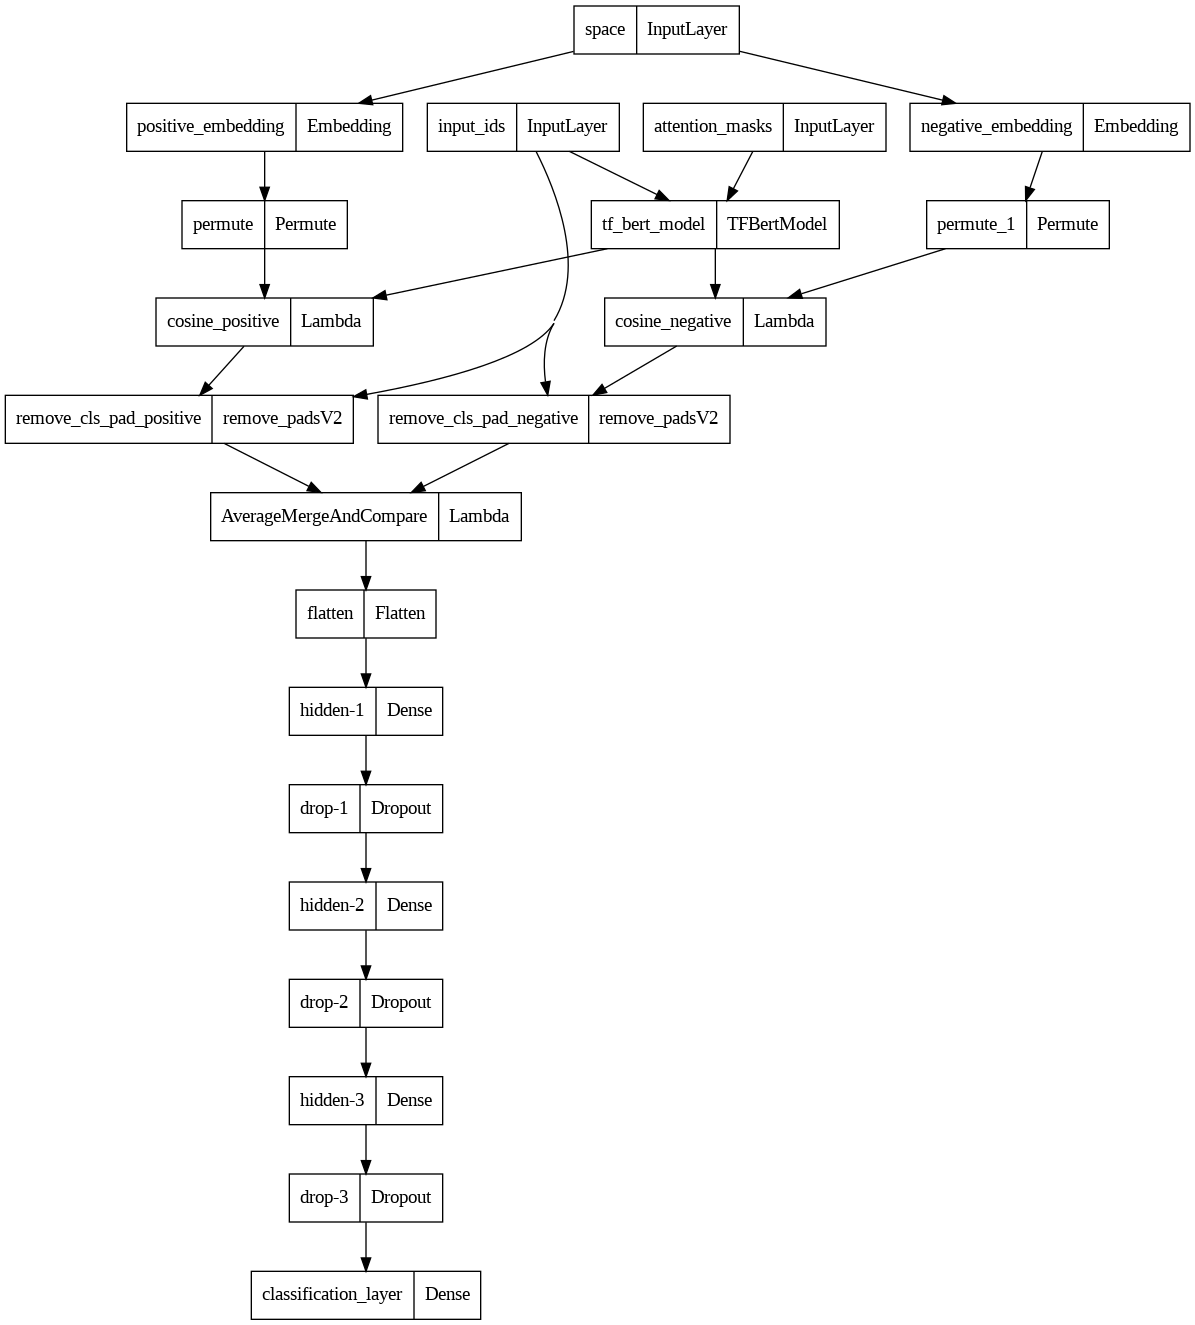

In [30]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model,to_file = "/content/sample_data/something.png", show_shapes=False)

## Model Training

In [31]:
# loss functions

# subtract this loss to decrease cosine similarity
# space_loss = tf.keras.losses.CosineSimilarity()(positive_embedding_np, negative_embedding_np)

# model.add_loss(-1*space_loss)

projection_loss = tf.keras.losses.CosineSimilarity()(tf.math.reduce_mean(positive_cosine, axis=1), tf.math.reduce_mean(negative_cosine, axis=1))
model.add_loss((1.0/(1.01 + projection_loss)))

In [32]:
# cross entropy loss
crossEntropLoss = tf.keras.losses.BinaryCrossentropy(from_logits = False)

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

model.compile(loss = crossEntropLoss , optimizer = optimizer, metrics=["accuracy"])

In [33]:
len(train_gen) // BATCH_SIZE

1093

In [34]:
# callbacks

BASE_PATH = "/gdrive/Shareddrives/Thesis/"

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath= BASE_PATH + "imdb_bestWeights.h5",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto",
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True)

In [ ]:
EPOCHS = 3
history = model.fit(
    train_ds,
    steps_per_epoch = len(train_gen) // BATCH_SIZE,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = [modelcheckpoint]
)

Epoch 1/3
1093/1093 [==============================] - ETA: 0s - loss: 0.9921 - accuracy: 0.7753
Epoch 1: val_loss improved from inf to 0.90549, saving model to /gdrive/Shareddrives/Thesis/imdb_bestWeights.h5
1093/1093 [==============================] - 439s 385ms/step - loss: 0.9921 - accuracy: 0.7753 - val_loss: 0.9055 - val_accuracy: 0.8177
Epoch 2/3
1093/1093 [==============================] - ETA: 0s - loss: 0.9246 - accuracy: 0.8103
Epoch 2: val_loss improved from 0.90549 to 0.89352, saving model to /gdrive/Shareddrives/Thesis/imdb_bestWeights.h5
1093/1093 [==============================] - 420s 384ms/step - loss: 0.9246 - accuracy: 0.8103 - val_loss: 0.8935 - val_accuracy: 0.8243
Epoch 3/3
1093/1093 [==============================] - ETA: 0s - loss: 0.9139 - accuracy: 0.8148
Epoch 3: val_loss improved from 0.89352 to 0.88206, saving model to /gdrive/Shareddrives/Thesis/imdb_bestWeights.h5
1093/1093 [==============================] - 433s 396ms/step - loss: 0.9139 - accuracy: 0.8

In [ ]:
# UNCOMMENT THIS CELL AFTER MODEL TRAINING

# save model history

with open(f"{BASE_PATH}/imdb_training_history.pkl","wb") as hist:
  pickle.dump(history.history,hist)

In [35]:

# load best weights
model.load_weights(f"{BASE_PATH}imdb_bestWeights.h5")

In [36]:
# %cd "/gdrive/Shareddrives/Thesis/code/Rahul"

In [37]:
# !unzip "/gdrive/Shareddrives/Thesis/code/Rahul/vaderSentiment-master.zip" -d "/gdrive/Shareddrives/Thesis/code/Rahul/"

In [38]:
# prepare test data for evaluation:
test_gen   = dataset(test_df["review"].values,test_df["sentiment"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)
test_ds = tf.data.Dataset.from_generator(test_gen,
                                            output_signature = 
                                           ({"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [39]:
test_df

,review,sentiment
0,with a little dressing up this movie could be ...,0.0
1,i just want to comment to the woman above that...,1.0
2,ever since i first encountered the divine ms m...,1.0
3,first off im an american i havent seen any com...,1.0
4,soap opera about a small town married woman ka...,1.0
...,...,...
7495,dont waste your time one of those coollooking ...,0.0
7496,robin williams does his best to combine comedy...,1.0
7497,when you see the cover of the dvd youre convin...,1.0
7498,heart pounding erotic drama are the words that...,1.0


In [40]:
# get performance metrics
predictions = model.predict(test_ds)

235/235 [==============================] - 65s 264ms/step


In [41]:
def predictionLabels(i):

  if i < 0.5:
    return 0.0
  else:
    return 1.0

getLabels = np.vectorize(predictionLabels)

In [42]:
predictedLabels = getLabels(predictions)
predictedLabels.shape

(7500, 1)

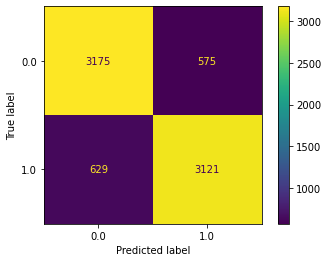

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

confusion_matrix(test_df.sentiment.values, predictedLabels)
ConfusionMatrixDisplay.from_predictions(test_df.sentiment.values, predictedLabels)

In [44]:
print(classification_report(test_df.sentiment.values, predictedLabels))

              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      3750
         1.0       0.84      0.83      0.84      3750

    accuracy                           0.84      7500
   macro avg       0.84      0.84      0.84      7500
weighted avg       0.84      0.84      0.84      7500



## Model Interpretability Using LINE

In [45]:
# ...

## Model interpretability Using Dynamic Projections

In [46]:
# SETUP:
# take a sentence, get 64 tokens, choose tokens that have maximum cosine similarity score
# from already trained model
# take such words from both classes 
# plot them on a tsne plot
# [PAD] and [CLS] should not be a problem since they'll result in 0 cosine similarity (already take care in remove_pads)

In [47]:
neg_reviews = test_df.loc[test_df.sentiment == 0.0].reset_index(drop=True)
pos_reviews = test_df.loc[test_df.sentiment == 1.0].reset_index(drop=True)

In [48]:
pos_reviews

,review,sentiment
0,i just want to comment to the woman above that...,1.0
1,ever since i first encountered the divine ms m...,1.0
2,first off im an american i havent seen any com...,1.0
3,soap opera about a small town married woman ka...,1.0
4,ive heard a lot of different opinions about th...,1.0
...,...,...
3745,i second the motion to make this into a movie ...,1.0
3746,robin williams does his best to combine comedy...,1.0
3747,when you see the cover of the dvd youre convin...,1.0
3748,heart pounding erotic drama are the words that...,1.0


In [49]:
neg_reviews

,review,sentiment
0,with a little dressing up this movie could be ...,0.0
1,i cannot vote on this because i wouldnt watch ...,0.0
2,no matter what youve heard fame is not a good ...,0.0
3,if youve seen atlantis then youd know that wha...,0.0
4,without a shadow of a doubt this is and probab...,0.0
...,...,...
3745,the most famous thing about this movie is that...,0.0
3746,i dont usually like tv movies i reckon that if...,0.0
3747,i hate to comment on something i didnt finish ...,0.0
3748,that jamie foxx would ever deliver such a wond...,0.0


In [50]:
layer_outputs = [layer.output for layer in model.layers]
len(layer_outputs)

37

In [51]:
layer_outputs[2]

<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'attention_masks')>

In [52]:
# get latent vector representations -- 7th layer of model2
layer_outputs = [layer.output for layer in model.layers]

activation_model_pos = Model(inputs = model.input, outputs = model.get_layer("remove_cls_pad_positive").output)   # (None,128,300)
activation_model_neg = Model(inputs = model.input, outputs = model.get_layer("remove_cls_pad_negative").output)   # (None,128,300)

In [53]:
cpostitives = activation_model_pos.predict(test_ds)

235/235 [==============================] - 67s 270ms/step


In [54]:
cpostitives.shape

(7500, 128, 300)

In [55]:
# testing again
for ele in test_ds.take(1):
  tempout = ele

In [56]:
t_ids = tempout[0]["input_ids"]
t_attmasks = tempout[0]["attention_masks"]
t_spaceids = tempout[0]["space"]

In [57]:
t_ids

<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101,  2007,  1037, ...,     0,     0,     0],
       [  101,  1045,  2074, ...,  3427,  2023,   102],
       [  101,  2412,  2144, ...,  1998,  1997,   102],
       ...,
       [  101,  2004,  1045, ...,  2453,  2022,   102],
       [  101,  4914,  2135, ..., 10667,  8303,   102],
       [  101,  1045,  2145, ...,     0,     0,     0]], dtype=int32)>

In [58]:
test_df.iloc[0]

review       with a little dressing up this movie could be ...
sentiment                                                  0.0
Name: 0, dtype: object

In [59]:
tokenizer.batch_decode(t_ids)[0]

'[CLS] with a little dressing up this movie could be served for thanksgiving dinner not only is is boring implausible historically inaccurate and poorly directed the best actors were the bit players mainly because they had so few lines to say a waste of time even for war fanatics [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [60]:
t_idsZerod = tf.where(tf.equal(t_ids,101) | tf.equal(t_ids,102),0,t_ids)
t_idsZerod

<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[    0,  2007,  1037, ...,     0,     0,     0],
       [    0,  1045,  2074, ...,  3427,  2023,     0],
       [    0,  2412,  2144, ...,  1998,  1997,     0],
       ...,
       [    0,  2004,  1045, ...,  2453,  2022,     0],
       [    0,  4914,  2135, ..., 10667,  8303,     0],
       [    0,  1045,  2145, ...,     0,     0,     0]], dtype=int32)>

In [61]:
t_idsZerod[0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([    0,  2007,  1037,  2210, 11225,  2039,  2023,  3185,  2071,
        2022,  2366,  2005, 15060,  4596,  2025,  2069,  2003,  2003,
       11771, 17727, 28128,  7028,  7145, 24949,  1998,  9996,  2856,
        1996,  2190,  5889,  2020,  1996,  2978,  2867,  3701,  2138,
        2027,  2018,  2061,  2261,  3210,  2000,  2360,  1037,  5949,
        1997,  2051,  2130,  2005,  2162,  5470, 17592,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [62]:
cpostitives[0][-76]

array([-0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0., -0., -0., -0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,
        0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,
       -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0.,
        0., -0., -0., -0.,  0.,  0.,  0., -0., -0.,  0., -0., -0., -0.,
       -0., -0.,  0., -0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0.,
        0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,
       -0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,
       -0.,  0.,  0., -0., -0., -0., -0., -0.,  0.,  0., -0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0., -0.,  0.,
        0.,  0., -0., -0.,  0.,  0., -0., -0., -0., -0.,  0.,  0

In [63]:
# clearly cpostitives is getting us the correct output corresponding to an example

In [64]:
# take 32 examples from positive class and 32 from negative class (i.e a batch)
# then for each batch, get cpostitives and cnegatitives
# for postive batch:
# take first example and get top 10 tokens from it ranked in order of highest cosine similarites with 300  tokens from positive projection vector
# for same example take top 10 tokens from it ranked in order of highest average cosine simlarity with 300 tokens from negative projection vector

# now get their the embeddings of all 20 from bert, separately for 10
# plot all embeddings on a tSNE chart with differenct colors corresponding to projection spaces

In [65]:
def get_TFDataset(dataframe):

  data_gen   = dataset(dataframe["review"].values,dataframe["sentiment"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)
  data_ds = tf.data.Dataset.from_generator(data_gen,
                                            output_signature = 
                                           ({"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

  return data_ds

def getCosineSimlarities(MODEL, ds_object):

  activation_model_pos = Model(inputs = MODEL.input, outputs = MODEL.get_layer("remove_cls_pad_positive").output)   # (None,1,300)
  activation_model_neg = Model(inputs = MODEL.input, outputs = MODEL.get_layer("remove_cls_pad_negative").output)   # (None,1,300)
  # activation_model_bertEmbeddings = Model(inputs = MODEL.input, outputs = MODEL.get_layer("tf_bert_model").output[0])

  pos_cosine = activation_model_pos.predict(ds_object)
  neg_cosine = activation_model_neg.predict(ds_object)
  # bertEmbeddings = activation_model_bertEmbeddings.predict(ds_object)
  bertEmbeddings = None

  return pos_cosine, neg_cosine, bertEmbeddings

In [66]:
# get the dataset object to be fed as input to model for making predictions
pos_ds = get_TFDataset(pos_reviews[0:100])

In [67]:
# get the dataset object to be fed as input to model for making predictions
neg_ds = get_TFDataset(neg_reviews[0:100])

In [68]:
# sanity check
for ele in neg_ds.take(1):
  t_neg = ele
  
t_neg

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[  101,  2007,  1037, ...,     0,     0,     0],
         [  101,  1045,  3685, ...,  3185,  2323,   102],
         [  101,  2053,  3043, ...,  7987, 15056,   102],
         ...,
         [  101,  2092,  2023, ...,  2008,  2001,   102],
         [  101,  2821,  6203, ...,  2032,  2019,   102],
         [  101,  2108,  1037, ..., 18251,  1037,   102]], dtype=int32)>,
  'attention_masks': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
  'space': <tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         ...,
         [  0,   1,   2, ..., 297, 298, 29

In [69]:
# sanity check
for ele in pos_ds.take(1):
  t_pos = ele
t_pos

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[  101,  1045,  2074, ...,  3427,  2023,   102],
         [  101,  2412,  2144, ...,  1998,  1997,   102],
         [  101,  2034,  2125, ...,  2028,  2838,   102],
         ...,
         [  101, 11430,  2358, ..., 16827,  1996,   102],
         [  101,  2178,  2742, ...,     0,     0,     0],
         [  101,  2123,  2102, ...,  2228,  1996,   102]], dtype=int32)>,
  'attention_masks': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
  'space': <tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         ...,
         [  0,   1,   2, ..., 297, 298, 29

In [70]:
# get cosine similarites of first batch of positive reviews with both projection spaces
posData_posProjSpace, posData_negProjSpace, posBertEmbeddings = getCosineSimlarities(model, pos_ds)

4/4 [==============================] - 4s 203ms/step


In [71]:
posData_posProjSpace.shape, posData_negProjSpace.shape

((100, 128, 300), (100, 128, 300))

In [72]:
negData_posProjSpace, negData_negProjSpace, negBertEmbeddings = getCosineSimlarities(model, neg_ds)

4/4 [==============================] - 5s 209ms/step


In [73]:
negData_posProjSpace.shape, negData_negProjSpace.shape

((100, 128, 300), (100, 128, 300))

In [74]:
posData_posProjSpace

array([[[-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.0715225 , -0.00956883, -0.01232964, ..., -0.07310642,
         -0.09911183, -0.0124768 ],
        [-0.11685545, -0.00163144, -0.04583045, ..., -0.01127035,
         -0.03595766,  0.00952253],
        ...,
        [-0.10675836,  0.04376175, -0.0087338 , ...,  0.01289652,
          0.01648336, -0.02451405],
        [-0.14829452, -0.01848528, -0.04395801, ...,  0.04163829,
          0.03269952, -0.01197457],
        [-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        ,  0.        ]],

       [[-0.        ,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.0243705 ,  0.00512092,  0.04915986, ..., -0.08467456,
         -0.10317715, -0.01765487],
        [-0.03377694, -0.00741601,  0.02464756, ..., -0.02571603,
         -0.07078011, -0.00216918],
        ...,
        [-0.08143084, -0.01155171,  0.032585  , ...,  

In [75]:
posData_posProjSpace.shape

(100, 128, 300)

In [76]:
firstSent = pd.DataFrame(posData_posProjSpace[0])

In [77]:
firstSent["tokens"] = tokenizer.batch_decode(t_pos[0]["input_ids"][0])

In [78]:
firstSent[[106, "tokens"]]

,106,tokens
0,0.000000,[CLS]
1,0.076611,i
2,0.176303,just
3,0.125953,want
4,0.162825,to
...,...,...
123,0.234229,it
124,0.217355,i
125,0.210055,watched
126,0.210635,this


In [79]:
firstSent.iloc[firstSent[1].sort_values(ascending = False)[0:3].index, -1]

77        ##t
76      doesn
116    really
Name: tokens, dtype: object

In [80]:
'''
each token must be having some maxima with one of the 300 dimensions
include only that one
'''

'\neach token must be having some maxima with one of the 300 dimensions\ninclude only that one\n'

In [81]:
tokens_dict = dict()
for idx, token in enumerate(firstSent["tokens"].values):
  maxCosine = np.max(firstSent.iloc[idx,:-1])
  maxDim    = np.argmax(firstSent.iloc[idx,:-1])
  
  if token in tokens_dict and tokens_dict[token][0] < maxCosine:
    tokens_dict[token] = (maxCosine, maxDim)
    continue

  tokens_dict[token] = (maxCosine, maxDim)

In [82]:
tokens_dict

{'[CLS]': (-0.0, 0),
 'i': (0.21735464, 106),
 'just': (0.21397212, 106),
 'want': (0.13769814, 271),
 'to': (0.18320273, 106),
 'comment': (0.13698873, 281),
 'the': (0.20349124, 245),
 'woman': (0.14497983, 106),
 'above': (0.11091378, 18),
 'that': (0.20220318, 106),
 'movie': (0.1995888, 271),
 'does': (0.23127837, 106),
 'credit': (0.19205645, 281),
 'beethoven': (0.13039055, 281),
 'in': (0.22945754, 106),
 'begging': (0.1492379, 281),
 'beginning': (0.21201159, 106),
 'credits': (0.20426008, 281),
 'they': (0.18225642, 271),
 'show': (0.18111068, 245),
 'it': (0.23422949, 106),
 'thank': (0.22880635, 281),
 'you': (0.20597345, 281),
 'think': (0.20481873, 106),
 'this': (0.21063489, 106),
 'is': (0.25993937, 106),
 'an': (0.27009928, 106),
 'amazing': (0.22230877, 106),
 'picked': (0.1736505, 281),
 'right': (0.16764212, 106),
 'music': (0.18075693, 281),
 'for': (0.16956145, 189),
 'mood': (0.1975132, 106),
 'of': (0.2148156, 106),
 'animation': (0.16205898, 106),
 'wonderful':

In [83]:
# tokens_dict has max CosineSim against each token

In [84]:
# [x for x if prob[x] == token_dict[x]]

In [85]:
# if I get a word with a cosine value for a dimension, then I will only print it if its cosine is equal to its global maximum cosine

In [ ]:
# We want a cluster of words for each dimension in the projection space
# For each column in the data frame add top ten words to the dictionary

In [86]:
res = dict()

for index, col in enumerate(firstSent.columns):
  if col != "tokens":
    res[col] = list()

    # first sort the column in descending order wrt cosine sim values
    # get corresponding tokens
    # if a token is appears the second time, only add if the cosine value is global maximum
    sortedBy_column = firstSent.iloc[firstSent[col].sort_values(ascending = False).index, :]
    # print(sortedBy_column)
    # print("*"*50)
    # sortedBy_columns is complete dataframe sorted in descending order of values by column = "col"; shape = (128,301)
    # now we we want to keep appending the top then tokens to it if the token's cosine similarity is absolute maximum
    count = 1
    for row in sortedBy_column.values:

      token = row[-1]
      
      if count < 11 and token not in res[col]:
        res[col].append(token)
        count+=1
        



      # **************************************************
      # **************************************************
      # print(token, row[index], tokens_dict[token])
    #   if count < 11 and abs(row[index]-tokens_dict[token]) < 0.000001:
    #     print(token)
    #     res[col].append(token)
    #     count+=1

    #     # if token not in res[col]:
    #     #   res[col].append(token)
    #     #   count+=1
    #     # else:
    # break
      # **************************************************
      # **************************************************


    # for sims in firstSent.iloc[firstSent[col].sort_values(ascending = False).index, :].values:
    #   cosines = sims[:-1]
    #   if max(cosines) != tokens_dict[sims[-1]]:
    #     continue
    #   else:
    #     res[col].append(sims[-1])
      
    #   if len(res[col]) > 5:
    #     break
    # res[col].append(firstSent.iloc[firstSent[col].sort_values(ascending = False)[0:3].index, -1].values)
    # res[col].append(firstSent.loc[(firstSent[col]) > 0,"tokens"].values)

In [87]:
for key, val in res.items():
  print(key, val)

0 ['[CLS]', '[SEP]', 'i', 'want', 'doesn', 'the', 'woman', '##t', 'give', 'above']
1 ['##t', 'doesn', 'really', 'well', 'hope', 'they', 'very', 'up', 'for', 'always']
2 ['is', 'does', 'amazing', 'very', 'beethoven', 'doesn', 'and', 'has', 'comment', 'movie']
3 ['for', 'laugh', 'to', 'humor', 'beethoven', 'parents', 'feel', '##t', 'never', 'ages']
4 ['great', 'at', 'all', 'colors', 'picked', 'very', 'and', 'mood', 'the', 'good']
5 ['for', 'never', 'feel', 'to', 'parents', 'really', 'have', 'can', 'all', 'it']
6 ['in', 'the', 'i', 'for', 'humor', 'think', 'beginning', '##ika', 'is', 'wonderful']
7 ['up', 'do', 'the', 'children', 'in', 'picked', 'shows', 'well', 'teaches', 'hope']
8 ['movie', 'just', 'this', 'they', 'above', 'i', 'comment', 'want', 'are', 'right']
9 ['amazing', 'very', 'they', 'picked', 'wonderful', 'the', 'think', 'just', 'well', 'is']
10 ['for', 'of', 'picked', 'music', 'you', 'the', '##t', 'just', 'all', 'to']
11 ['same', 'the', 'never', 'do', 'give', 'always', 'hope',

### MeanCosineSimilarities

In [ ]:
# normalized vectors for positive projection space
norm_posData_posProj = posData_posProjSpace.mean(axis= -1)
norm_posData_negProj = posData_negProjSpace.mean(axis= -1)

In [ ]:
x = tokenizer.batch_decode(t_pos[0]["input_ids"][0])
y1 = norm_posData_posProj[0]

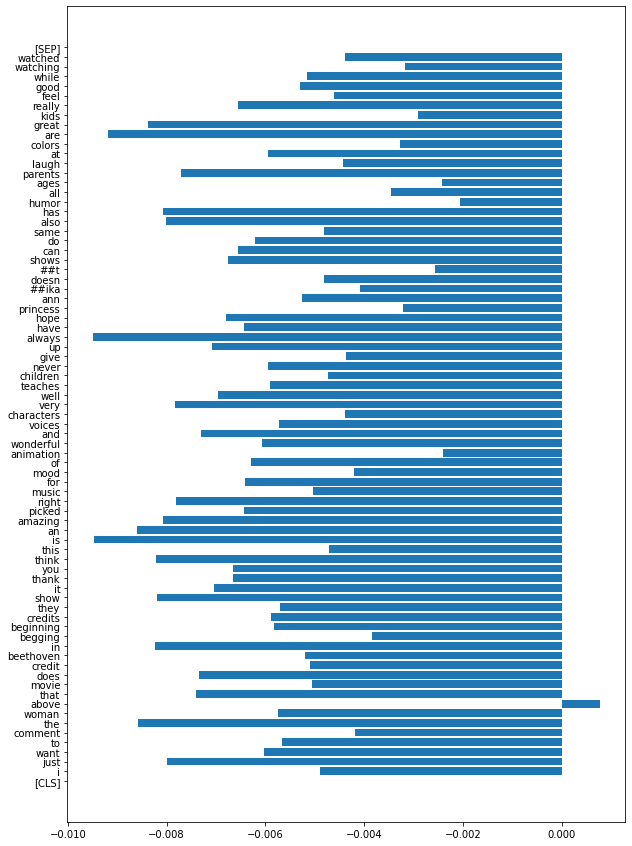

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y1)
plt.show()

In [ ]:
# x2 = tokenizer.batch_decode(t_pos[0]["input_ids"][0])
y2 = norm_posData_negProj[0]

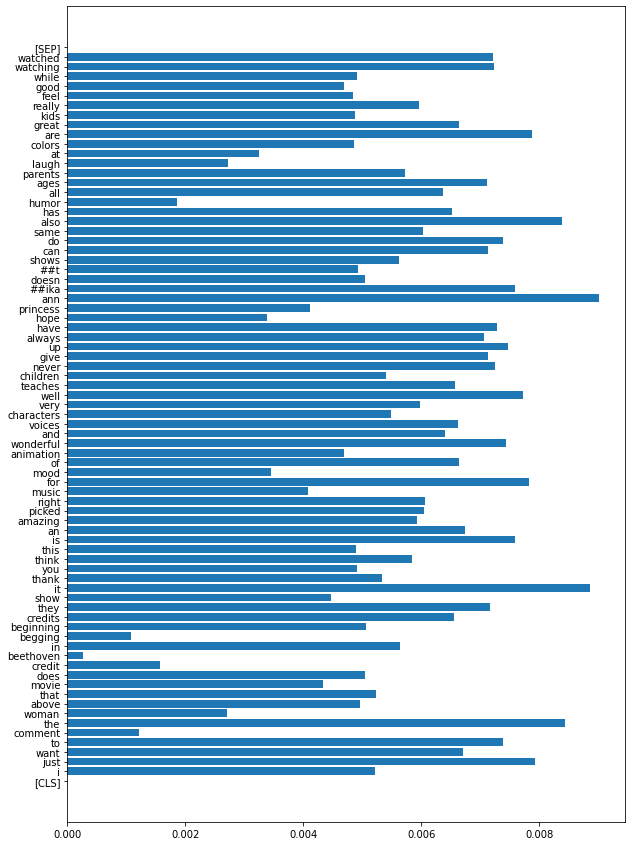

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y2)
plt.show()

### MaxCosineSimilarities

In [ ]:
# normalized vectors for positive projection space
norm_posData_posProj = posData_posProjSpace.max(axis= -1)
norm_posData_negProj = posData_negProjSpace.max(axis= -1)

In [ ]:
x = tokenizer.batch_decode(t_pos[0]["input_ids"][0])
y1 = norm_posData_posProj[0]

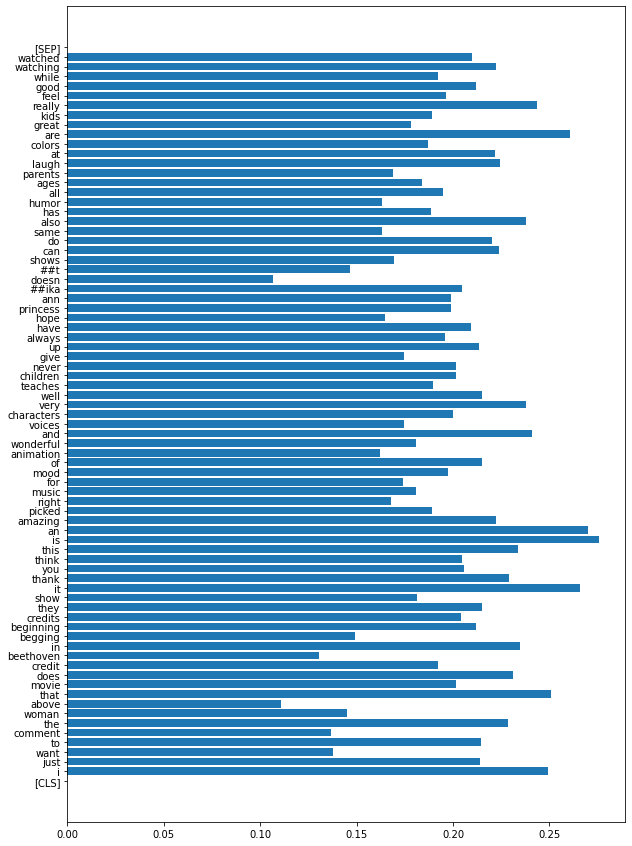

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y1)
plt.show()

In [ ]:
y2 = norm_posData_negProj[0]

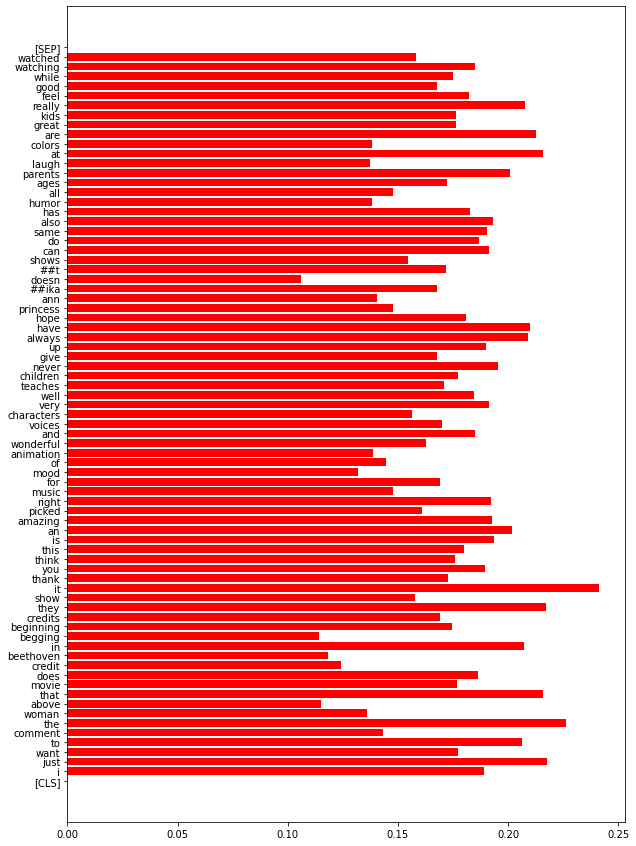

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,15))
axes.barh(x,y2, color = "red")
plt.show()

In [ ]:
t_pos[0]["input_ids"]

<tf.Tensor: shape=(32, 128), dtype=int32, numpy=
array([[  101,  1045,  2074, ...,  3427,  2023,   102],
       [  101,  2412,  2144, ...,  1998,  1997,   102],
       [  101,  2034,  2125, ...,  2028,  2838,   102],
       ...,
       [  101, 11430,  2358, ..., 16827,  1996,   102],
       [  101,  2178,  2742, ...,     0,     0,     0],
       [  101,  2123,  2102, ...,  2228,  1996,   102]], dtype=int32)>

In [ ]:
pos_reviews.iloc[0]

review       i just want to comment to the woman above that...
sentiment                                                  1.0
Name: 0, dtype: object

In [ ]:
print(tokenizer.batch_decode(t_pos[0]["input_ids"][0]))

['[CLS]', 'i', 'just', 'want', 'to', 'comment', 'to', 'the', 'woman', 'above', 'that', 'the', 'movie', 'does', 'credit', 'beethoven', 'in', 'the', 'begging', 'in', 'the', 'beginning', 'credits', 'they', 'show', 'it', 'thank', 'you', 'i', 'think', 'this', 'is', 'an', 'amazing', 'movie', 'they', 'picked', 'just', 'the', 'right', 'music', 'for', 'the', 'mood', 'of', 'the', 'movie', 'the', 'animation', 'is', 'wonderful', 'and', 'they', 'picked', 'the', 'voices', 'for', 'the', 'characters', 'very', 'well', 'it', 'teaches', 'children', 'to', 'never', 'give', 'up', 'and', 'to', 'always', 'have', 'hope', 'princess', 'ann', '##ika', 'doesn', '##t', 'give', 'up', 'and', 'it', 'shows', 'children', 'that', 'they', 'can', 'do', 'the', 'same', 'the', 'movie', 'also', 'has', 'humor', 'in', 'in', 'for', 'all', 'ages', 'parents', 'and', 'children', 'to', 'laugh', 'at', 'the', 'colors', 'in', 'this', 'movie', 'are', 'great', 'and', 'kids', 'can', 'really', 'feel', 'good', 'while', 'they', 'are', 'watchi

In [ ]:
posData_posProjSpace[0]

array([[-0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.0715225 , -0.00956883, -0.01232964, ..., -0.07310642,
        -0.09911183, -0.0124768 ],
       [-0.11685545, -0.00163144, -0.04583045, ..., -0.01127035,
        -0.03595766,  0.00952253],
       ...,
       [-0.10675836,  0.04376175, -0.0087338 , ...,  0.01289652,
         0.01648336, -0.02451405],
       [-0.14829452, -0.01848528, -0.04395801, ...,  0.04163829,
         0.03269952, -0.01197457],
       [-0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        ,  0.        ]], dtype=float32)

In [ ]:
negData_negProjSpace.shape

(100, 128, 300)

In [ ]:
# positive samples with positive projection space, take mean 
# then take maximum of means of words - Which word is that

In [ ]:
posData_posProjSpace.shape

(100, 128, 300)

In [ ]:
negData_negProjSpace.shape

(100, 128, 300)

In [ ]:
def AverageSentenceEmbedding(matrix):


  Length = tf.math.count_nonzero(tf.math.reduce_sum(matrix, axis=2,keepdims=True), axis=1, keepdims=True,dtype = np.float32)   # (None,1,1)

  # now obtain average of cosine similarities
  matrixSum = np.sum(matrix,axis=1, keepdims=True)    # (None,1,300)
  matrixAverage = np.divide(matrixSum, Length)


  return matrixAverage

In [ ]:
posProjectionSpace  = AverageSentenceEmbedding(posData_posProjSpace)
negProjectionSpace = AverageSentenceEmbedding(posData_negProjSpace)

In [ ]:
# we have access to each sentence's input ids, as well as their bert embeddings right now
# we want to see which tokens from a sentence have maximum cosine similarity with pos_projection space
# get those indices, and we have those token ids
# now we want to fetch the words corresponding to those token ids

In [ ]:
np.squeeze(posProjectionSpace).shape

(100, 300)

In [ ]:
from sklearn.manifold import TSNE
m = TSNE(n_components=2, learning_rate= 50,
                   init='pca', perplexity=3, n_iter= 2500)

In [ ]:
combined = np.vstack([np.squeeze(posProjectionSpace), np.squeeze(negProjectionSpace)])

In [ ]:
combined.shape

(200, 300)

In [ ]:
tSNE_combined = m.fit_transform(combined)

In [ ]:
tSNE_combined.shape

(200, 2)

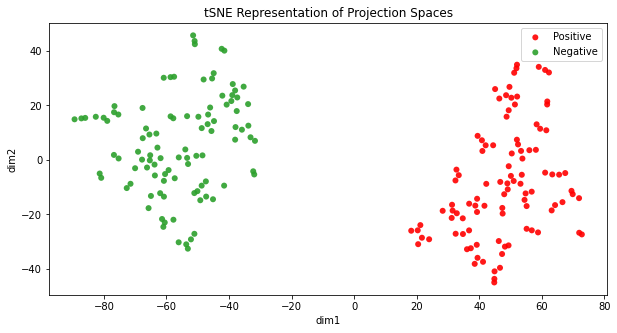

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

for color in ['RED', 'tab:GREEN']:
    n = 750
    if color == "RED":
      x, y = tSNE_combined[:100,0], tSNE_combined[:100,1]

    else:
      x, y = tSNE_combined[100:,0], tSNE_combined[100:,1]

    ax.scatter(x, y, c=color, label= "Positive" if color == "RED" else "Negative",
               alpha=0.9, edgecolors='none')

ax.legend()
ax.set_xlabel("dim1")
ax.set_ylabel("dim2")
ax.set_title("tSNE Representation of Projection Spaces")

plt.show()

In [ ]:
t_pos

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[  101,  1045,  2074, ...,  3427,  2023,   102],
         [  101,  2412,  2144, ...,  1998,  1997,   102],
         [  101,  2034,  2125, ...,  2028,  2838,   102],
         ...,
         [  101, 11430,  2358, ..., 16827,  1996,   102],
         [  101,  2178,  2742, ...,     0,     0,     0],
         [  101,  2123,  2102, ...,  2228,  1996,   102]], dtype=int32)>,
  'attention_masks': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
  'space': <tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         ...,
         [  0,   1,   2, ..., 297, 298, 29

In [ ]:
t_neg

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[  101,  2007,  1037, ...,     0,     0,     0],
         [  101,  1045,  3685, ...,  3185,  2323,   102],
         [  101,  2053,  3043, ...,  7987, 15056,   102],
         ...,
         [  101,  2092,  2023, ...,  2008,  2001,   102],
         [  101,  2821,  6203, ...,  2032,  2019,   102],
         [  101,  2108,  1037, ..., 18251,  1037,   102]], dtype=int32)>,
  'attention_masks': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>,
  'space': <tf.Tensor: shape=(32, 300), dtype=int32, numpy=
  array([[  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         [  0,   1,   2, ..., 297, 298, 299],
         ...,
         [  0,   1,   2, ..., 297, 298, 29

In [ ]:
# tokens
posData_posProjSpace[0].shape

(128, 300)

In [ ]:
pos_reviews.review.values[0]

'i just want to comment to the woman above that the movie does credit beethoven in the begging in the beginning credits they show it thank you i think this is an amazing movie they picked just the right music for the mood of the movie the animation is wonderful and they picked the voices for the characters very well it teaches children to never give up and to always have hope princess annika doesnt give up and it shows children that they can do the same the movie also has humor in in for all ages parents and children to laugh at the colors in this movie are great and kids can really feel good while they are watching it i watched this movie for the first time now i am a huge fan and im sure your child will be too walmart sells tons of barbie and the magic of pegasus stuff so your child can continue to enjoy the movie even when they arent watching it thank you'

In [ ]:
wordidx = np.where(np.max(posData_posProjSpace[0], axis = 1) > 0.1)
wordidx[0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [ ]:
t_pos[0]["input_ids"][0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101,  1045,  2074,  2215,  2000,  7615,  2000,  1996,  2450,
        2682,  2008,  1996,  3185,  2515,  4923, 15461,  1999,  1996,
       12858,  1999,  1996,  2927,  6495,  2027,  2265,  2009,  4067,
        2017,  1045,  2228,  2023,  2003,  2019,  6429,  3185,  2027,
        3856,  2074,  1996,  2157,  2189,  2005,  1996,  6888,  1997,
        1996,  3185,  1996,  7284,  2003,  6919,  1998,  2027,  3856,
        1996,  5755,  2005,  1996,  3494,  2200,  2092,  2009, 12011,
        2336,  2000,  2196,  2507,  2039,  1998,  2000,  2467,  2031,
        3246,  4615,  5754,  7556,  2987,  2102,  2507,  2039,  1998,
        2009,  3065,  2336,  2008,  2027,  2064,  2079,  1996,  2168,
        1996,  3185,  2036,  2038,  8562,  1999,  1999,  2005,  2035,
        5535,  3008,  1998,  2336,  2000,  4756,  2012,  1996,  6087,
        1999,  2023,  3185,  2024,  2307,  1998,  4268,  2064,  2428,
        2514,  2204,  2096,  2027,  2024,  3

In [ ]:
print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[0])

[CLS]


In [ ]:
posData_posProjSpace[0]

array([[-0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.08163896, -0.00519264, -0.04930513, ...,  0.01633385,
        -0.08853861,  0.01800421],
       [-0.11440402, -0.03474047, -0.0289792 , ...,  0.03251273,
        -0.06183091, -0.00425492],
       ...,
       [-0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [-0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        ,  0.        ]], dtype=float32)

In [ ]:
for index in wordidx[0]:

  print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index], end = " ")

i just want to comment to the woman above that the movie does credit beethoven in the begging in the beginning credits they show it thank you i think this is an amazing movie they picked just the right music for the mood of the movie the animation is wonderful and 

In [ ]:
wordidx

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]),)

In [ ]:
wordidx = np.max(negData_negProjSpace[0], axis = 1)

for index, value in enumerate(wordidx):

  print(tokenizer.batch_decode(t_neg[0]["input_ids"][0])[index], value)

[CLS] -0.0
with 0.14962037
a 0.19610451
little 0.18122384
dressing 0.11276428
up 0.2102472
this 0.21123213
movie 0.17655957
could 0.17111628
be 0.16747603
served 0.12769462
for 0.18070684
thanksgiving 0.18078734
dinner 0.19181241
not 0.17206861
only 0.17331004
is 0.19242164
is 0.16482055
boring 0.15680087
imp 0.21057408
##laus 0.21477674
##ible 0.21914577
historically 0.17207064
inaccurate 0.20952332
and 0.1688066
poorly 0.18803966
directed 0.17549708
the 0.18310021
best 0.17155759
actors 0.15304416
were 0.2007365
the 0.17797641
bit 0.14577496
players 0.16893278
mainly 0.19142509
because 0.18842193
they 0.16758199
had 0.17586595
so 0.15893844
few 0.16769025
lines 0.15681103
to 0.17464554
say 0.14797041
a 0.20212096
waste 0.19981961
of 0.20840083
time 0.18655002
even 0.18663758
for 0.2156041
war 0.11954684
fan 0.12941265
##atics 0.15216817
[SEP] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0
[PAD] 0.0

In [ ]:
'''
in pos space: words with higher positive polarity will show up - opposite behaviour in negative space and vice versa

for each threshold - get sum of polarities of all words (for 100 sentences)

'''

'\nin pos space: words with higher positive polarity will show up - opposite behaviour in negative space and vice versa\n\nfor each threshold - get sum of polarities of all words (for 100 sentences)\n\n'

In [ ]:
# imdb
# hatebase
# PeaceViolent public dataset?

In [ ]:
# collect communal violence dataset that occurs through social media (YT mainly). (ex Hindus vs Muslims, Veg - Non Veg)
# we have the data collection pipeline
# find what kind of communal violence took place in India / Pakistan

In [ ]:
'''

1. See how vader is used
2. Map the polarity of words from vader
3. Set some thresholds, for all the words we get --> sum up their polarities
4. Plot CosineSim Thresholds vs Sum(Polarities)

'''

'\n\n1. See how vader is used\n2. Map the polarity of words from vader\n3. Set some thresholds, for all the words we get --> sum up their polarities\n4. Plot CosineSim Thresholds vs Sum(Polarities)\n\n'

In [ ]:
# words with max cosine > 0.25
wordidx = np.where(np.max(negData_negProjSpace[0], axis = 1) > 0.15)

for index in wordidx[0]:

  print(tokenizer.batch_decode(t_neg[0]["input_ids"][0])[index])

a
little
up
this
movie
could
be
for
thanksgiving
dinner
not
only
is
is
boring
imp
##laus
##ible
historically
inaccurate
and
poorly
directed
the
best
actors
were
the
players
mainly
because
they
had
so
few
lines
to
a
waste
of
time
even
for
##atics


In [ ]:
df_sent.columns = ["token", "sentiment", "stdev", "values"]
df_sent.head()

,token,sentiment,stdev,values
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"


In [ ]:
sent_dict = dict()
for tok, sent in zip(df_sent.token.values,df_sent.sentiment.values) :
  sent_dict[tok] = sent

In [ ]:
sent_dict["to"]

In [ ]:
# words with max cosine > 0.25
wordidx = np.where(np.max(posData_posProjSpace[0], axis = 1) > 0.25)

tokens1 = list()
for index in wordidx[0]:

  tokens1.append(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index])
  # print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index])

In [ ]:
print(tokens1)

['comment', 'to', 'show', 'mood']


In [ ]:
polarity025 = 0.0
for ele in tokens1:
  polarity025 += sent_dict.get(ele,0)

In [ ]:
polarity005, polarity010, polarity015, polarity020, polarity021, polarity025

(10.4, 10.4, 10.4, 1.5, 0.0, 0.0)

In [ ]:
# words with max cosine > 0.25
# wordidx = np.where(np.max(posData_posProjSpace[0], axis = 1) > 0.25)
# now with negative projection space
sentence = 0
negs_tokens20 = dict()
while sentence < 32:
  wordidx = np.where(np.max(posData_negProjSpace[sentence], axis = 1) > 0.20)
  tokens1 = list()
  for index in wordidx[0]:

    tokens1.append(tokenizer.batch_decode(t_pos[0]["input_ids"][sentence])[index])
    # print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index])
  negs_tokens20[sentence] = tokens1
  print(sentence)
  sentence +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [ ]:
# s_tokens has tokens with offset of 0.05
# s_tokens10, negs_tokens10 - Done
# s_tokens15, negs_tokens15 - Done
# s_tokens20, negs_tokens20
# s_tokens35

In [ ]:
# negs_tokens10

In [ ]:
# s_tokens10, polarity10 - Done
# s_tokens15, polarity15 - Done
# s_tokens20, polarity20 - Done

# negs_tokens10, neg_polarity10 - Done
# negs_tokens15, neg_polarity15 -> error :(


In [ ]:
polarity20 = dict()
for sentence in s_tokens20:
  p005 = 0.0
  for token in s_tokens20[sentence]:
    p005 += sent_dict.get(token,0)
  polarity20[sentence] = p005

In [ ]:
# negsentence polarity
neg_polarity20 = dict()
for sentence in negs_tokens20:
  p005 = 0.0
  for token in negs_tokens20[sentence]:
    p005 += sent_dict.get(token,0)
  neg_polarity20[sentence] = p005

In [ ]:
polarity010

In [ ]:
polarity015

In [ ]:
polarity20

In [ ]:
neg_polarity10

In [ ]:
neg_polarity15

In [ ]:
neg_polarity20

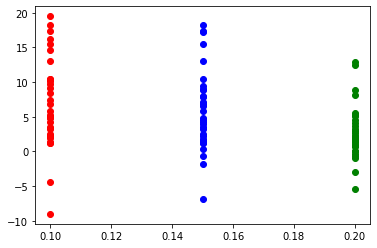

In [ ]:
for polarity in polarity010:
  plt.scatter(0.10,polarity010[polarity], color = "red")

for polarity in polarity015:
  plt.scatter(0.15,polarity015[polarity], color = "blue")

for polarity in polarity20:
  plt.scatter(0.20,polarity20[polarity], color = "green")
plt.show()

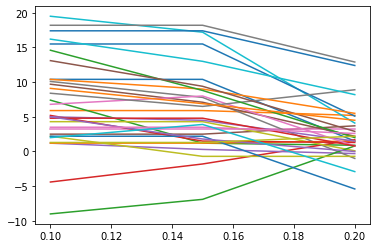

In [ ]:

for s_index in range(32):
  x = [0.10,0.15,0.20]
  y = [polarity010[s_index],polarity015[s_index],polarity20[s_index]]
  plt.plot(x,y)
plt.show()

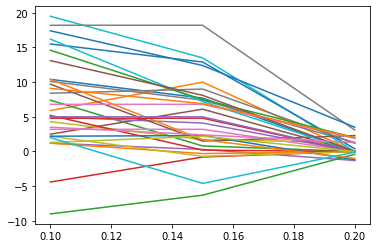

In [ ]:
for s_index in range(32):
  x = [0.10,0.15,0.20]
  y = [neg_polarity10[s_index],neg_polarity15[s_index],neg_polarity20[s_index]]
  plt.plot(x,y)
plt.show()

In [ ]:
s_tokens20

{0: ['to',
  'comment',
  'to',
  'the',
  'in',
  'in',
  'the',
  'beginning',
  'show',
  'thank',
  'you',
  'i',
  'the',
  'mood',
  'the',
  'and'],
 1: ['##s',
  'it',
  'i',
  'have',
  'on',
  'this',
  'under',
  'emmy',
  'her',
  'portrayal',
  'here',
  'is',
  '##des',
  'is',
  'masterpiece',
  'of',
  '##sta',
  '##tem',
  'shine',
  '##s',
  'this',
  'was',
  '##ignant',
  'for',
  'for',
  'grew',
  'up',
  'detail',
  'phenomena',
  '##l',
  'and',
  'ev',
  'woo',
  '##oo',
  '##oo',
  '##ond',
  '##ful',
  'life',
  'times'],
 2: ['im',
  '##t',
  'any',
  'im',
  '##db',
  'yet',
  'from',
  'a',
  'us',
  'viewer',
  'secondly',
  'in',
  'so',
  'in',
  'of',
  'comes',
  'american',
  'programming',
  'one',
  'is',
  'example',
  'of',
  'television',
  'to',
  'would',
  'script',
  '##ing',
  'feature',
  'namely',
  'those',
  'made',
  'by',
  '##eurs',
  'who',
  'had',
  'to',
  'make',
  'dramas',
  'more',
  'and',
  'allow',
  'organic',
  'characte

In [ ]:
negs_tokens20

{0: ['comment',
  'to',
  'in',
  'the',
  'beginning',
  'they',
  'this',
  'mood',
  'the',
  'animation'],
 1: ['this', 'under', 'her', 'this', 'up'],
 2: ['##db',
  'example',
  'television',
  '##eurs',
  'had',
  'dramas',
  'realistic',
  'and',
  'character',
  'development',
  'tack',
  'prime',
  'under'],
 3: ['takes', 'a', 'husband', 'life'],
 4: ['##e',
  'lot',
  'film',
  'then',
  'that',
  'give',
  'film',
  'my',
  'shocked',
  'through',
  'it',
  'but',
  'of',
  'and',
  'film',
  'made',
  'watching',
  'whole',
  'fact',
  'doesn'],
 5: ['keep',
  'this',
  'thought',
  'my',
  'what',
  'minutes',
  'after',
  'jaw',
  'the',
  'is',
  'can',
  'furthermore',
  'this',
  'candy',
  'style',
  'although',
  'at',
  '##t'],
 6: ['[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 7: ['movie',
  'very',
  'fan',
  'an',
  'had',
  'it',
  '##s',
  'of',
  'it',
  'terribly',
  'romance'],
 8: ['original', 'bar'],
 9:

In [ ]:
[(sent,pol) for sent,pol in polarity010.items() if pol < 0.0]

[(3, -4.400000000000001), (12, -9.0)]

In [ ]:
[(sent,pol) for sent,pol in polarity015.items() if pol < 0.0]

[(3, -1.8000000000000007), (12, -6.8999999999999995), (18, -0.7)]

In [ ]:
[(sent,pol) for sent,pol in polarity20.items() if pol < 0.0]

[(4, -0.30000000000000004),
 (7, -1.0000000000000004),
 (18, -0.7),
 (20, -5.4),
 (29, -2.9)]

In [ ]:
s_tokens10[3]

In [ ]:
np.sort(np.max(posData_posProjSpace[0], axis = 1))[::-1]

array([ 0.28367928,  0.27361298,  0.25846794,  0.2567309 ,  0.23229809,
        0.23036386,  0.22909796,  0.22841337,  0.222799  ,  0.21163484,
        0.20897613,  0.20807424,  0.20779014,  0.20567214,  0.20542979,
        0.20029488,  0.1998684 ,  0.1987663 ,  0.19853252,  0.19639128,
        0.19464648,  0.1933001 ,  0.19277774,  0.19270825,  0.19267467,
        0.19203955,  0.19176328,  0.18915385,  0.1882963 ,  0.18800393,
        0.18694088,  0.18574877,  0.18522975,  0.18468729,  0.18111327,
        0.18015519,  0.17918457,  0.17561908,  0.17444785,  0.17360322,
        0.1721769 ,  0.16864721,  0.16788839,  0.16692606,  0.16653143,
        0.16549495,  0.15814804,  0.15729396,  0.15670548,  0.15535133,
        0.1539587 , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [ ]:
np.max(posData_posProjSpace[0], axis = 1)

array([-0.        ,  0.15535133,  0.19464648,  0.19639128,  0.20567214,
        0.2567309 ,  0.25846794,  0.20779014,  0.16864721,  0.19267467,
        0.15814804,  0.15729396,  0.16788839,  0.1987663 ,  0.16692606,
        0.18468729,  0.222799  ,  0.17360322,  0.16653143,  0.23036386,
        0.20542979,  0.23229809,  0.1933001 ,  0.19277774,  0.28367928,
        0.15670548,  0.20897613,  0.22909796,  0.21163484,  0.19270825,
        0.19203955,  0.19853252,  0.17918457,  0.18111327,  0.18800393,
        0.1998684 ,  0.18694088,  0.1882963 ,  0.20029488,  0.16549495,
        0.1721769 ,  0.1539587 ,  0.18522975,  0.27361298,  0.18015519,
        0.22841337,  0.18915385,  0.19176328,  0.17561908,  0.17444785,
        0.18574877,  0.20807424, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [ ]:
wordidx = np.max(posData_posProjSpace[0], axis = 1)

for index, value in enumerate(wordidx):

  print(tokenizer.batch_decode(t_pos[0]["input_ids"][0])[index], value)

[CLS] -0.0
i 0.15535133
just 0.19464648
want 0.19639128
to 0.20567214
comment 0.2567309
to 0.25846794
the 0.20779014
woman 0.16864721
above 0.19267467
that 0.15814804
the 0.15729396
movie 0.16788839
does 0.1987663
credit 0.16692606
beethoven 0.18468729
in 0.222799
the 0.17360322
begging 0.16653143
in 0.23036386
the 0.20542979
beginning 0.23229809
credits 0.1933001
they 0.19277774
show 0.28367928
it 0.15670548
thank 0.20897613
you 0.22909796
i 0.21163484
think 0.19270825
this 0.19203955
is 0.19853252
an 0.17918457
amazing 0.18111327
movie 0.18800393
they 0.1998684
picked 0.18694088
just 0.1882963
the 0.20029488
right 0.16549495
music 0.1721769
for 0.1539587
the 0.18522975
mood 0.27361298
of 0.18015519
the 0.22841337
movie 0.18915385
the 0.19176328
animation 0.17561908
is 0.17444785
wonderful 0.18574877
and 0.20807424
they -0.0
picked -0.0
the -0.0
voices -0.0
for -0.0
the -0.0
characters -0.0
very -0.0
well -0.0
it -0.0
teaches -0.0
children -0.0
to -0.0
never -0.0
give -0.0
up -0.0
and

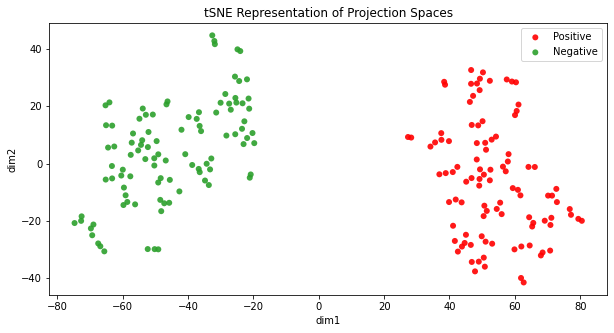

In [ ]:
# for negative projection space
fig, ax = plt.subplots(figsize = (10,5))

for color in ['RED', 'tab:GREEN']:
    n = 750
    if color == "RED":
      x, y = tSNE_combined[:100,0], tSNE_combined[:100,1]

    else:
      x, y = tSNE_combined[100:,0], tSNE_combined[100:,1]

    ax.scatter(x, y, c=color, label= "Positive" if color == "RED" else "Negative",
               alpha=0.9, edgecolors='none')

ax.legend()
ax.set_xlabel("dim1")
ax.set_ylabel("dim2")
ax.set_title("tSNE Representation of Projection Spaces")

plt.show()

## Vader Sentiment Polarity

In [ ]:
df_sent = pd.read_csv("/gdrive/Shareddrives/Thesis/code/Rahul/vaderSentiment-master/vaderSentiment/vader_lexicon.txt", sep = "\t", header = None)

In [ ]:
df_sent

,0,1,2,3
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"
...,...,...,...,...
7515,}:,-2.1,0.83066,"[-1, -1, -3, -2, -3, -2, -2, -1, -3, -3]"
7516,}:(,-2.0,0.63246,"[-3, -1, -2, -1, -3, -2, -2, -2, -2, -2]"
7517,}:),0.4,1.42829,"[1, 1, -2, 1, 2, -2, 1, -1, 2, 1]"
7518,}:-(,-2.1,0.70000,"[-2, -1, -2, -2, -2, -4, -2, -2, -2, -2]"
